# Train notebook - Airbus kaggle challenge

# Ship Detection- Project AIRBUS 2019
## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [1]:
BATCH_SIZE = 100
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = None
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 1000
MAX_TRAIN_EPOCHS = 10

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from pre_process import multi_rle_encode, rle_encode, rle_decode, masks_as_image, masks_as_color, balancing_train
from pre_process import make_image_gen, create_aug_gen
from sklearn.model_selection import train_test_split

SystemError: Parent module '' not loaded, cannot perform relative import

In [ ]:
ship_dir = '/Data/airbus-ship-detection/'
train_image_dir = os.path.join(ship_dir, 'Train')# Images for training
test_image_dir = os.path.join(ship_dir, 'Test')# Images for testing
masks = pd.read_csv(ship_dir + 'train_ship_segmentations_v2.csv') # Markers for ships

# Make balanced train data set

In [6]:
train_df_ids = balancing_train(df=masks, rate_of_has_ship=1, ship_dir=train_image_dir)
train_df = train_df_ids.merge(masks, on='ImageId')
training_set, validation_set = train_test_split(train_df, test_size=0.05)
print(len(training_set))
print(len(validation_set))

73457
3867


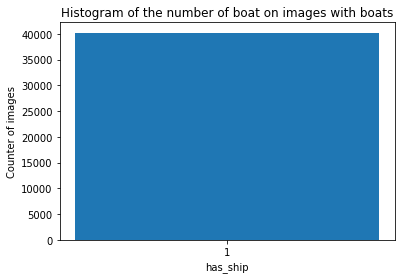

In [7]:
hist_images_count_boat = np.unique(train_df_ids.has_ship, return_counts=True)
plt.bar(hist_images_count_boat[0], hist_images_count_boat[1], width=0.4, tick_label=hist_images_count_boat[0])
plt.title('Histogram of the number of boat on images with boats')
plt.xlabel('has_ship')
plt.ylabel('Counter of images')
plt.show()

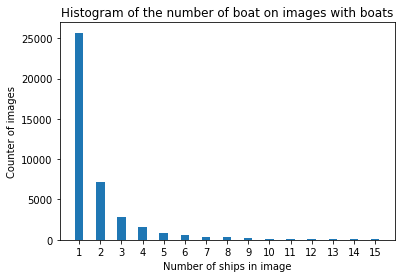

In [8]:
hist_images_count_boat = np.unique(train_df_ids.ships, return_counts=True)
plt.bar(hist_images_count_boat[0], hist_images_count_boat[1], width=0.4, tick_label=hist_images_count_boat[0])
plt.title('Histogram of the number of boat on images with boats')
plt.xlabel('Number of ships in image')
plt.ylabel('Counter of images')
plt.show()

# Decode all the RLEs into Images
We make a generator to produce batches of images

In [9]:
train_gen = make_image_gen(training_set, train_image_dir, BATCH_SIZE, IMG_SCALING)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (100, 768, 768, 3) 0.0 1.0
y (100, 768, 768, 1) 0 1


# Data aug

In [10]:
from keras.preprocessing.image import ImageDataGenerator
AUGMENT_BRIGHTNESS = False

dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

aug_gen = create_aug_gen(train_gen, image_gen, label_gen)
print('x', next(aug_gen)[0].shape)

x (100, 768, 768, 3)


# Build model

In [11]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from unet import get_unet
from unet_resnet50 import get_unet_resnet50

In [12]:
# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    Intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    Union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (Intersection + tresh) / (Union + tresh), axis=0)
# Intersection over Union for Background
def back_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)
# Loss function
def IoU_loss(in_gt, in_pred):
    #return 2 - back_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
    return 1 - IoU(in_gt, in_pred) 

#Dice
def dice_coef(y_true, y_pred, smooth=0.001):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_loss(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [16]:
#model = get_unet(input_shape=train_x.shape[1:], UPSAMPLE_MODE='SIMPLE', NET_SCALING=NET_SCALING)
model = get_unet_resnet50(input_shape=train_x.shape[1:])
model.summary()

C:\Users\Thibault\Anaconda3\envs\Deeplearning\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 774, 774, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 384, 384, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 384, 384, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard, Callback
weight_path = workspace_dir + "{}_weights.best.hdf5".format('model_1')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=2, verbose=1, mode='min',
                                   min_delta=0.001, cooldown=1, min_lr=1e-7)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=2) # probably needs to be more patient, but kaggle time is limited

log_dir = workspace_dir + "logs/log6"
tensorboard =  TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks_list = [checkpoint, reduceLROnPlat, early, tensorboard]

In [ ]:
model.compile(optimizer=Adam(), loss=dice_loss, 
                metrics=[IoU, back_IoU, dice_coef, 'binary_accuracy', true_positive_rate])

step_count_train = min(MAX_TRAIN_STEPS, training_set.shape[0]//BATCH_SIZE)
training_gen = make_image_gen(training_set, train_image_dir, BATCH_SIZE, IMG_SCALING)
training_aug_gen =  create_aug_gen(training_gen, image_gen, label_gen)

step_count_valid = validation_set.shape[0]//BATCH_SIZE
validation_gen = make_image_gen(validation_set, train_image_dir, BATCH_SIZE, IMG_SCALING)

print("step_count_train =", step_count_train)
print("step_count_valid =", step_count_valid)


loss_history = [model.fit_generator(training_aug_gen,
                                 steps_per_epoch=step_count_train,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 callbacks=callbacks_list,
                                 validation_data=validation_gen,
                                 validation_steps=step_count_valid,
                                workers=1 # the generator is not very thread safe
                                           )]

step_count_train = 734
step_count_valid = 38
Epoch 1/10


In [ ]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 15))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['IoU'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_IoU'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('IoU accuracy (%)')
    
    _ = ax3.plot(epochs, np.concatenate([mh.history['back_IoU'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_back_IoU'] for mh in loss_history]), 'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('back_IoU accuracy (%)')

show_loss(loss_history)

In [ ]:
pred_y = model.predict(next(validation_gen)[0])
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

## Prepare Full Resolution Model
Here we account for the scaling so everything can happen in the model itself

In [ ]:

if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(model_1)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = model_1
fullres_model.save('fullres_model_1.h5')

# Visualisation of predictions

In [ ]:
from matplotlib.cm import get_cmap
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, img))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')